Speaker: Ba Ngoc - Founder @ProtonX @VietAI Hanoi

- Bài tập phân loại ảnh sử dụng Transfer Learning - Bài tập có 4 phần cần hoàn thành

In [ ]:
#@title 1. Tải dữ liệu
train_folder = './data/cats_and_dogs_filtered/train'
valid_folder = './data/cats_and_dogs_filtered/validation'

!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O ./cats_and_dogs_filtered.zip

# Giải nén dữ liệu
main_folder = './data'
!unzip -q cats_and_dogs_filtered.zip -d $main_folder

--2021-04-10 07:25:39--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 173.194.76.128, 64.233.167.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M   189MB/s    in 0.3s    

2021-04-10 07:25:40 (189 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
# Sử dụng colab để review ảnh

In [ ]:
#@title 2. Tải Pretrained model - Inception V3

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O ./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-04-10 07:29:20--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 66.102.1.128, 142.251.5.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

./inception_v3_weig 100%[===================>]  83.84M   247MB/s    in 0.3s    

2021-04-10 07:29:21 (247 MB/s) - ‘./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model


# 1. Sử dụng kiến trúc của mô hình
from tensorflow.keras.applications.inception_v3 import InceptionV3

# 2. Khởi tạo mô hình
pre_trained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights=None)

local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# 3. Load tham số đã được train vào mô hình
pre_trained_model.load_weights(local_weights_file)

In [ ]:
# 4. Đóng băng (freeze) các lớp, trường hợp này chỉ sử dụng các tham số này 
# để inference (dự đoán) mà không sử dụng để training 

# 5. Câu hỏi (Có thể sử dụng các tham số này để tiếp tục huấn luyên không - Câu trả lời: Có)
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
# 6. Lấy layer ta muốn gắn thêm lớp phân loại theo bài toán của mình

#### TODO 3: Sử dụng lại mô hình đến layer mixed7

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output


In [ ]:
last_output

<KerasTensor: shape=(None, 7, 7, 768) dtype=float32 (created by layer 'mixed7')>

# 5. Xây dựng mô hình

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# 7. Duỗi features map thu được và đựa vào mạng nơ ron để phân loại
x = layers.Flatten()(last_output)
# 8. Thêm một lớp Dense
x = layers.Dense(1024, activation='relu')(x)
# 9. Thêm một lớp Dropout để cải thiện tính tổng quát của mô hình - tránh overfiting
x = layers.Dropout(0.2)(x)                  
# 10. Sử dụng activation sigmoid để phân loại 2 lớp
x = layers.Dense(1, activation='sigmoid')(x)           

# 11. Gắn mô hình phân loại của chúng ta vào pre trained model
model = Model( pre_trained_model.input, x) 

# 12. Bổ sung thuật toán trainining. RMSProp có khả năng điều chỉnh tốc độc học dựa vào độ lớn của đạo hàm

#### TODO 4: Compile thuật toán
model.compile(
    optimizer = RMSprop(lr=0.0001),
    loss = 'binary_crossentropy',  # hàm sai lệch, so sánh kết quả của mình với thật
    metrics=['acc']
)
              

In [ ]:
model.summary()

In [ ]:
#@title Tăng cường data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 13. Bổ sung tăng cường data cho tập train
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# 13. Không bổ sung tăng cường data cho tập validation
validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

# 14. Tiến hành load ảnh từ thư mục với tập train
train_generator = train_datagen.flow_from_directory(train_folder,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# 15. Tiến hành load ảnh từ thư mục với tập validation
validation_generator =  validation_datagen.flow_from_directory( valid_folder,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

In [ ]:
# 16. Tiến hành training 

#### TODO 5: Tiến hành training

history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 100,  # Trong một vòng lặp bộ data, còn chia nhỏ ra nữa, ở đây là 100 lần
    epochs = 3,  # Số lần lặp qua một tập dữ liệu
    validation_steps = 20,
    verbose = 2,
)

Epoch 1/3
100/100 - 53s - loss: 0.3505 - acc: 0.8590 - val_loss: 0.1017 - val_acc: 0.9625
Epoch 2/3
100/100 - 18s - loss: 0.2002 - acc: 0.9210 - val_loss: 0.2336 - val_acc: 0.9175
Epoch 3/3
100/100 - 18s - loss: 0.2135 - acc: 0.9215 - val_loss: 0.1372 - val_acc: 0.9600


# 6. Tải ảnh của bạn và tiến hành dự đoán

Saving Bat-Cuoi-Truoc-Nhung-07.jpg to Bat-Cuoi-Truoc-Nhung-07.jpg
User uploaded file "Bat-Cuoi-Truoc-Nhung-07.jpg" with length 55400 bytes
[[2.8892777e-05]]
Cat with output: [2.8892777e-05]


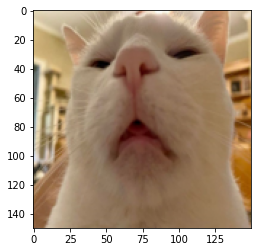

In [ ]:
#@title Tải ảnh
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
  image = plt.imread(fn)
  plt.imshow(image)
  

  image = Image.open(fn)
  # img = Image.fromarray(arr)
  image = image.resize(size=(150, 150))

  plt.imshow(image)
  data = np.asarray(image)
  data=np.expand_dims(data, 0)
  x = data / 255.0
  fi = model.predict(x)
  print(fi)
  print('Dog with output: {}'.format(fi[0])) if fi >= 0.5 else print('Cat with output: {}'.format(fi[0]))

In [ ]:
model.save('hieu.h5')